In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import LabelEncoder

# SUPUESTOS:
# - Tienes un archivo CSV (por ejemplo, "landmarks_data.csv") con columnas:
#   specimen_id, group, x1, y1, x2, y2, ..., xN, yN, centroid_size
#   (donde 'group' indica el morfotipo, por ejemplo, "lamarcki" o "rouxi").
#
# Nota: Si no tienes centroid_size en el CSV, debe calcularse previamente.
#
# Cargar los datos:


def ordenar_puntos(puntos):
    """
    Ordena los puntos en base al ángulo polar respecto al centroide.
    Este método es adecuado para conjuntos de puntos que forman un polígono
    convexo o casi convexo.
    """
    # Calcular el centroide
    centroide = np.mean(puntos, axis=0)
    
    # Calcular el ángulo polar de cada punto respecto al centroide
    angulos = np.arctan2(puntos[:, 1] - centroide[1], puntos[:, 0] - centroide[0])
    
    # Obtener el índice de ordenamiento basado en el ángulo
    indices_orden = np.argsort(angulos)
    
    # Retornar los puntos ordenados
    return puntos[indices_orden]

# Cargar los dos CSV por separado
df1 = pd.read_csv("/storage/recol_conchas/zona_alta/lat/landmarks_data.csv")  # CSV del primer grupo
df2 = pd.read_csv("/storage/recol_conchas/zona_baja/lat/landmarks_data.csv")  # CSV del segundo grupo

# Agregar la columna "group" a cada DataFrame
df1["group"] = "zona_alta"  # o el nombre correspondiente al grupo 1
df2["group"] = "zona_baja"     # o el nombre correspondiente al grupo 2

# Combinar ambos DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# (Opcional) Guardar el CSV combinado para su uso posterior
df.to_csv("landmarks_combinados.csv", index=False)



df = pd.read_csv("landmarks_combinados.csv")
# Extraer las columnas de forma: asumimos que las columnas de landmarks comienzan a partir de la tercera columna
# (las dos primeras son specimen_id y group)
# Extraer identificadores y grupo
specimen_ids = df["specimen_id"].values
groups = df["group"].values

landmark_cols = [col for col in df.columns if col not in ["specimen_id", "group"]]
N_landmarks = len(landmark_cols) // 2  # Número total de landmarks

def get_pts(row):
    # Extrae los valores como enteros y los reorganiza en un array (N_landmarks, 2)
    landmarks = row[landmark_cols].to_numpy(dtype=int)
    puntos = landmarks.reshape((N_landmarks, 2))
    # Para el cálculo, se convierten temporalmente a float
    puntos_float = puntos.astype(float)
    # Ordena los puntos usando la función
    puntos_ordenados = ordenar_puntos(puntos_float)
    # Vuelve a enteros (redondeando si es necesario) y devuelve la lista de puntos
    puntos_ordenados = np.rint(puntos_ordenados).astype(int)
    return puntos_ordenados.tolist()

# Aplica la función a cada fila para crear la columna 'pts'
df['pts'] = df.apply(get_pts, axis=1)
df = df.drop(columns=landmark_cols)



In [2]:
def calcular_centroide(pts):
    # Convierte la lista de puntos a un array de NumPy (forma: (N, 2))
    puntos = np.array(pts)
    # Si el polígono no está cerrado, lo cerramos añadiendo el primer punto al final
    if not np.array_equal(puntos[0], puntos[-1]):
        puntos = np.vstack([puntos, puntos[0]])
    
    area = 0.0
    Cx = 0.0
    Cy = 0.0
    n = len(puntos) - 1  # El último punto es el mismo que el primero
    
    # Cálculo del área y del centroide
    for i in range(n):
        x0, y0 = puntos[i]
        x1, y1 = puntos[i+1]
        factor = (x0 * y1 - x1 * y0)
        area += factor
        Cx += (x0 + x1) * factor
        Cy += (y0 + y1) * factor

    area = area / 2.0
    if area == 0:
        raise ValueError("El área del polígono es cero, la fórmula no es aplicable.")
    
    Cx = Cx / (6.0 * area)
    Cy = Cy / (6.0 * area)
    
    return Cx, Cy, puntos  # Devuelve el centroide y el polígono cerrado



# 2) Calcular Centroid Size para cada configuración
def compute_centroid_size(pts):
    # Convierte la lista de puntos a un array de NumPy (forma: (N, 2))
    pts_arr = np.array(pts)
    # Calcula el centroide (media de las coordenadas)
    centroid_x, centroid_y, puntos = calcular_centroide(pts)
    # Calcula el tamaño del centroide como la raíz cuadrada de la suma
    # de las distancias al cuadrado de cada punto al centroide
    size = np.sqrt(np.sum((pts_arr - [centroid_x, centroid_y])**2))
    return [centroid_x, centroid_y], size, puntos

df[['centroid', 'centroid_size', 'pts']] = df['pts'].apply(lambda pts: pd.Series(compute_centroid_size(pts)))


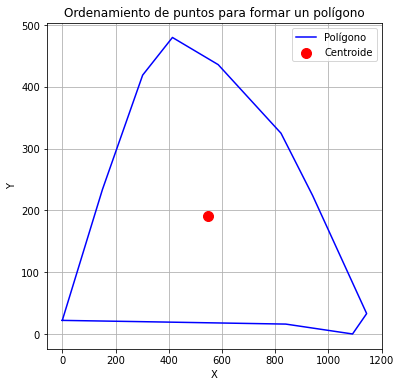

In [3]:
import numpy as np
import matplotlib.pyplot as plt

specimen_id = 'LanZaPV25.JPG'

puntos_centroide =  list(df[df['specimen_id'] == specimen_id]['centroid'])[0]

index = df[df['specimen_id'] == specimen_id].first_valid_index()
x = [p[0] for p in df[df['specimen_id'] == specimen_id]['pts'][index]]
y = [p[1] for p in df[df['specimen_id'] == specimen_id]['pts'][index]]

# Graficar los puntos y el polígono resultante
plt.figure(figsize=(6, 6))
plt.plot(x, y, 'b-', label='Polígono')
plt.scatter(puntos_centroide[0], puntos_centroide[1], color='red', s=100, label='Centroide')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Ordenamiento de puntos para formar un polígono")
plt.legend()
plt.grid(True)
plt.show()

El Generalized Procrustes Analysis (GPA) es una técnica estadística utilizada principalmente en morfometría y análisis de formas. Su objetivo es alinear un conjunto de configuraciones de puntos (como landmarks) de diferentes objetos o especímenes, eliminando las variaciones debidas a la posición, escala y orientación. Esto permite comparar únicamente las diferencias en la forma pura.

En resumen, el GPA realiza los siguientes pasos:

    Traslación: Centra cada configuración de puntos en su centroide.

    Escalado: Ajusta cada configuración para que tengan el mismo tamaño (por ejemplo, utilizando el tamaño del centroide).

    Rotación: Rota las configuraciones de manera que se minimicen las diferencias entre puntos correspondientes, permitiendo obtener una forma promedio o "consenso".

Este procedimiento es fundamental para estudios comparativos de formas, ya que permite separar la variación de la forma real de la variación que se debe a factores geométricos triviales.

In [4]:
import numpy as np
import pandas as pd

def align_to_reference(shape, ref_angle=0):
    """
    Alinea una configuración de puntos (shape: array de forma (N, 2)) 
    al ángulo de referencia ref_angle (en radianes) usando PCA.
    Retorna la forma rotada.
    """
    # Calcular el centroide y centrar la forma
    centroid = np.mean(shape, axis=0)
    centered = shape - centroid
    
    # Realizar SVD (equivalente a PCA en este caso)
    U, s, Vt = np.linalg.svd(centered, full_matrices=False)
    # La dirección principal es la primera fila de Vt
    principal_direction = Vt[0]
    current_angle = np.arctan2(principal_direction[1], principal_direction[0])
    
    # Calcular el ángulo de rotación necesario para alinear al ref_angle
    rotation_angle = ref_angle - current_angle
    R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                  [np.sin(rotation_angle),  np.cos(rotation_angle)]])
    
    # Rotar la forma (conservando el centro original)
    rotated = centered.dot(R.T) + centroid
    return rotated

def perform_gpa(df, tol=1e-6, max_iter=100, ref_angle=0):
    """
    Realiza el Generalized Procrustes Analysis (GPA) para cada grupo del DataFrame y 
    actualiza la columna 'pts' de cada specimen con la configuración alineada (centrada y escalada)
    además de reorientarla según el ángulo de referencia (ref_angle, por defecto 0 radianes).
    
    Se espera que df tenga las columnas:
      - 'specimen_id'
      - 'group'
      - 'pts': lista de puntos [ [x,y], ... ]
      - 'centroide': [cx, cy] (centroide de la configuración original)
      - 'centroid_size': tamaño del centroide (escala de la configuración original)
    
    La función además añade, para cada grupo, una nueva fila con specimen_id = "<grupo>_gpa" 
    que contiene:
      - pts: la configuración promedio (consenso) reorientada
      - centroide: el centroide del consenso
      - centroid_size: el tamaño del centroide del consenso
    """
    new_rows = []
    grupos = df['group'].unique()
    
    for grupo in grupos:
        # Seleccionar el subconjunto para el grupo
        group_idx = df['group'] == grupo
        group_df = df[group_idx]
        n_specimens = group_df.shape[0]
        
        # Extraer y normalizar cada configuración:
        # Se centra (restando el centroide) y se escala (dividiendo por centroid_size)
        shapes = []
        for idx, row in group_df.iterrows():
            pts = np.array(row['pts'])  # (N, 2)
            centro = np.array(row['centroid'])
            size = row['centroid_size']
            centered = pts - centro
            scaled = centered / size if size != 0 else centered
            shapes.append(scaled)
        shapes = np.array(shapes)  # forma: (n_specimens, N, 2)
        
        # Inicializar el consenso como el promedio de las configuraciones escaladas, normalizado a unidad
        consensus = np.mean(shapes, axis=0)
        cons_norm = np.sqrt(np.sum(consensus**2))
        consensus = consensus / cons_norm if cons_norm != 0 else consensus
        
        # Iteración para alinear las configuraciones al consenso
        final_aligned = None
        for it in range(max_iter):
            aligned_shapes = []
            for shape in shapes:
                # Optimización de rotación para alinear 'shape' a 'consensus'
                M = shape.T.dot(consensus)
                U, _, Vt = np.linalg.svd(M)
                R = Vt.T.dot(U.T)
                aligned = shape.dot(R)
                aligned_shapes.append(aligned)
            aligned_shapes = np.array(aligned_shapes)
            new_consensus = np.mean(aligned_shapes, axis=0)
            new_norm = np.sqrt(np.sum(new_consensus**2))
            new_consensus = new_consensus / new_norm if new_norm != 0 else new_consensus
            
            if np.linalg.norm(new_consensus - consensus) < tol:
                consensus = new_consensus
                final_aligned = aligned_shapes
                break
            consensus = new_consensus
        if final_aligned is None:
            final_aligned = aligned_shapes
        
        # Aplicar la rotación de referencia a cada specimen y actualizar la fila
        for i, (index, row) in enumerate(group_df.iterrows()):
            new_shape = final_aligned[i]  # configuración alineada (centrada y escalada)
            # Alinear al ángulo de referencia
            new_shape_aligned = align_to_reference(new_shape, ref_angle=ref_angle)
            # Recalcular centroide y tamaño de la configuración alineada
            new_centroid = np.mean(new_shape_aligned, axis=0)
            new_size = np.sqrt(np.sum((new_shape_aligned - new_centroid)**2))
            df.at[index, 'pts'] = new_shape_aligned.tolist()
            df.at[index, 'centroid'] = new_centroid.tolist()
            df.at[index, 'centroid_size'] = new_size
        
        # Calcular el consenso final y alinearlo a la referencia
        consensus_final = np.mean(final_aligned, axis=0)
        consensus_final_aligned = align_to_reference(consensus_final, ref_angle=ref_angle)
        cons_centroide = np.mean(consensus_final_aligned, axis=0)
        cons_size = np.sqrt(np.sum((consensus_final_aligned - cons_centroide)**2))
        
        # Construir la fila nueva para el consenso del grupo
        new_row = {
            'specimen_id': f"{grupo}_gpa",
            'group': grupo,
            'pts': consensus_final_aligned.tolist(),
            'centroid': cons_centroide.tolist(),
            'centroid_size': cons_size
        }
        new_rows.append(new_row)
    
    # Añadir las filas de consenso al DataFrame original
    df_new = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    return df_new



def plot_gpa_group(df, group):
    """
    Grafica para un grupo dado:
      - En gris claro se muestran las configuraciones (figuras) individuales
      - En rojo se muestra la configuración promedio (consenso) obtenida con GPA
    Se asume que el DataFrame tiene las columnas:
      - 'specimen_id': identificador, en el caso del consenso contiene el sufijo "gpa"
      - 'group': grupo al que pertenece la figura
      - 'pts': lista de puntos [ [x,y], ... ]
    """
    # Filtrar el DataFrame para el grupo especificado
    df_group = df[df['group'] == group]
    
    # Separar la fila de GPA (consenso) identificada por specimen_id que contenga "gpa"
    consensus_row = df_group[df_group['specimen_id'].str.contains("gpa")].iloc[0]
    
    # Filtrar las figuras individuales (aquellas que no son el consenso)
    individual_rows = df_group[~df_group['specimen_id'].str.contains("gpa")]
    
    plt.figure(figsize=(8, 8))
    
    # Graficar cada figura individual en gris claro
    for idx, row in individual_rows.iterrows():
        pts = np.array(row['pts'])
        # Cerrar el polígono si es necesario (añadir el primer punto al final)
        if not np.array_equal(pts[0], pts[-1]):
            pts = np.vstack([pts, pts[0]])
        plt.plot(pts[:, 0], pts[:, 1], color='lightgrey', linewidth=1)
    
    # Graficar la configuración GPA (consenso) en rojo
    pts_consensus = np.array(consensus_row['pts'])
    if not np.array_equal(pts_consensus[0], pts_consensus[-1]):
        pts_consensus = np.vstack([pts_consensus, pts_consensus[0]])
    plt.plot(pts_consensus[:, 0], pts_consensus[:, 1], color='red', linewidth=2, label=f'GPA Consensus ({group})')
    
    plt.title(f"Configuración GPA vs. Figuras individuales para el grupo {group}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()




In [5]:
df = perform_gpa(df)

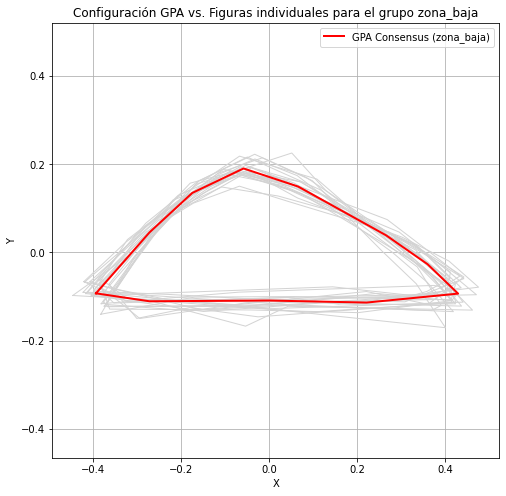

In [6]:
plot_gpa_group(df, 'zona_baja')

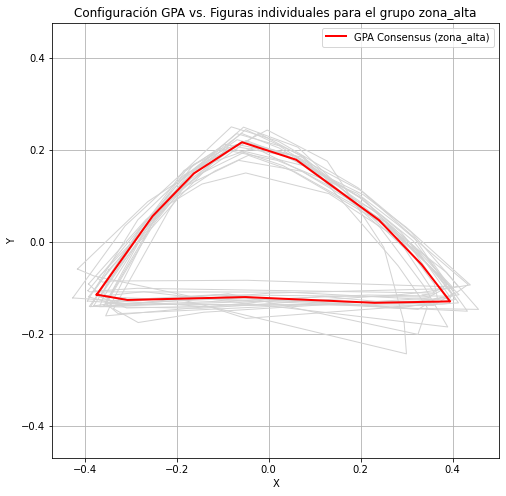

In [7]:
plot_gpa_group(df, 'zona_alta')

Extraer las coordenadas de la forma:
Dado que en tu DataFrame cada fila tiene la columna pts (una lista de puntos [x,y][x,y]), convertiremos esos puntos en columnas separadas (por ejemplo, x1,y1,x2,y2,…x1​,y1​,x2​,y2​,…) para poder usarlas como variables dependientes en la regresión.

Crear el predictor alométrico:
Se calcula el logaritmo del tamaño del centroide (por ejemplo, \log(\text{centroid_size})) para usarlo como predictor.

Ajustar el modelo con interacción:
Con las variables dependientes (las coordenadas) y los predictores (el log del tamaño y el grupo, además de su interacción), se ajusta un modelo multivariado usando, por ejemplo, la función MANOVA de statsmodels. La interacción \log(\text{centroid_size}) \times \text{group} permite evaluar si la dirección de la variación alométrica difiere entre grupos.

Interpretación:
Si el test multivariado para la interacción es significativo, se rechaza la hipótesis nula de que la dirección de los cambios alométricos es la misma entre morfotipos.

In [8]:
import numpy as np
import pandas as pd
from statsmodels.multivariate.manova import MANOVA

def run_mancova_by_group(df):
    """
    Para cada grupo en el DataFrame, realiza una regresión multivariada (MANCOVA)
    en la que las variables dependientes son las coordenadas de la forma (extraídas de 'pts')
    y la covariable es el logaritmo del tamaño del centroide (log_centroid_size).
    
    Se prueba la hipótesis nula de que la dirección de los cambios alométricos no difiere
    dentro del mismo grupo (es decir, que la relación forma-tamaño es homogénea).
    
    La función imprime y retorna los resultados de la prueba para cada grupo.
    """
    results = {}
    grupos = df['group'].unique()
    
    for grupo in grupos:
        # Subconjunto para el grupo
        df_group = df[df['group'] == grupo].copy()
        
        # Crear la variable predictora: log del tamaño del centroide.
        # Se asume que 'centroid_size' ya está calculado.
        df_group['log_centroid_size'] = np.log(df_group['centroid_size'])
        
        # Extraer las coordenadas de la forma a partir de la columna 'pts'.
        # Se asume que todos los registros tienen el mismo número de landmarks.
        n_landmarks = len(df_group['pts'].iloc[0])
        for i in range(n_landmarks):
            df_group[f'x{i+1}'] = df_group['pts'].apply(lambda pts: pts[i][0])
            df_group[f'y{i+1}'] = df_group['pts'].apply(lambda pts: pts[i][1])
        
        # Construir la lista de variables dependientes: todas las coordenadas x e y.
        dep_vars = " + ".join([f"x{i+1}" for i in range(n_landmarks)] + [f"y{i+1}" for i in range(n_landmarks)])
        
        # Fórmula de la regresión multivariada con el covariable log_centroid_size.
        formula = f"{dep_vars} ~ log_centroid_size"
        
        # Ajustar el modelo MANOVA (que en este caso actúa como MANCOVA).
        manova_model = MANOVA.from_formula(formula, data=df_group)
        test_result = manova_model.mv_test()
        
        results[grupo] = test_result
        
        print(f"Resultados para el grupo {grupo}:")
        print(test_result)
        print("\n" + "="*80 + "\n")
    
    return results

In [9]:
model = run_mancova_by_group(df)

Resultados para el grupo zona_alta:
                        Multivariate linear model
                                                                          
--------------------------------------------------------------------------
       Intercept               Value          Num DF Den DF F Value Pr > F
--------------------------------------------------------------------------
          Wilks' lambda               0.0000 20.0000 0.0000  0.0000    nan
         Pillai's trace               1.0839 20.0000 0.0000 -0.0000    nan
 Hotelling-Lawley trace 191642537334913.8125 20.0000 0.0000  0.0000    nan
    Roy's greatest root 191642537334913.7188 20.0000 0.0000  0.0000    nan
--------------------------------------------------------------------------
                                                                          
--------------------------------------------------------------------------
     log_centroid_size          Value         Num DF Den DF F Value Pr > F
--------------

LinAlgError: Singular matrix

Para cada grupo del DataFrame, realiza una regresión multivariada (usando una solución OLS matricial) en la que las variables respuesta son las coordenadas de la forma (extraídas de la columna pts, que se transforman en columnas x1,y1,x2,y2,…x1​,y1​,x2​,y2​,…) y la única variable predictora (además del intercepto) es el logaritmo del tamaño del centroide (almacenado en log_centroid_size).
La pendiente asociada a log_centroid_size es el vector alométrico de ese grupo.

Luego se calcula el ángulo (usando la fórmula del coseno) entre los vectores alométricos de cada par de grupos y se obtiene el ángulo medio como proxy para comparar la dirección de los cambios alométricos entre grupos.
La hipótesis nula que se quiere evaluar es que los vectores alométricos no son más similares de lo esperado por casualidad (es decir, que las direcciones son homogéneas).

In [16]:
import numpy as np
import pandas as pd

def compute_alometric_vector(df_group):
    """
    Dado un DataFrame (df_group) para un grupo, construye la matriz de respuesta Y
    (con las coordenadas de forma) y la matriz de predictores X (constante y log_centroid_size)
    y calcula los coeficientes de la regresión multivariada:
    
         Y = B0 + B1 * log_centroid_size   + error
    
    Retorna el vector alométrico, que es la fila B1 (coeficientes asociados a log_centroid_size).
    """
    # Construir la matriz de predictores: columna de 1's y la variable log_centroid_size
    X = np.column_stack((np.ones(df_group.shape[0]), df_group['log_centroid_size'].values))
    
    # Se asume que las columnas de coordenadas fueron creadas previamente.
    # Se consideran todas las columnas que empiezan con 'x' o 'y'
    coord_cols = [col for col in df_group.columns if col.startswith('x') or col.startswith('y')]
    Y = df_group[coord_cols].values  # forma: (n_specimens, p) con p = 2 * n_landmarks
    
    # Solución OLS: B = (X'X)^(-1) X'Y
    B = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    # El vector alométrico es la segunda fila (coeficiente de log_centroid_size)
    slope_vector = B[1, :]
    return slope_vector

def angle_between(u, v):
    """
    Calcula el ángulo en grados entre dos vectores u y v.
    """
    dot = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    cosine_angle = np.clip(dot / (norm_u * norm_v), -1.0, 1.0)
    angle_rad = np.arccos(cosine_angle)
    return np.degrees(angle_rad)

def compare_alometric_directions(df):
    """
    Para cada grupo en el DataFrame, ajusta una regresión multivariada (forma ~ log_centroid_size)
    y extrae el vector alométrico (pendiente asociado a log_centroid_size). Luego calcula los ángulos
    entre cada par de vectores alométricos y reporta el ángulo medio entre grupos.
    
    Se asume que el DataFrame tiene:
      - 'pts': lista de puntos [ [x, y], ... ]
      - 'centroid_size': tamaño del centroide
      - 'group': identificador de grupo
    """
    # Generar la variable log_centroid_size (si no existe)
    if 'log_centroid_size' not in df.columns:
        df['log_centroid_size'] = np.log(df['centroid_size'])
    
    # Crear columnas de coordenadas a partir de 'pts'
    n_landmarks = len(df['pts'].iloc[0])
    for i in range(n_landmarks):
        df[f'x{i+1}'] = df['pts'].apply(lambda pts: pts[i][0])
        df[f'y{i+1}'] = df['pts'].apply(lambda pts: pts[i][1])
    
    groups = df['group'].unique()
    alometric_vectors = {}
    
    for grupo in groups:
        df_group = df[df['group'] == grupo].copy()
        slope_vec = compute_alometric_vector(df_group)
        alometric_vectors[grupo] = slope_vec
        print(f"Vector alométrico para el grupo {grupo}:")
        print(slope_vec)
        print("-"*40)
    
    # Calcular los ángulos entre cada par de vectores alométricos
    group_list = list(alometric_vectors.keys())
    angles = []
    for i in range(len(group_list)):
        for j in range(i+1, len(group_list)):
            u = alometric_vectors[group_list[i]]
            v = alometric_vectors[group_list[j]]
            angle = angle_between(u, v)
            print(f"Ángulo entre {group_list[i]} y {group_list[j]}: {angle:.2f}°")
            angles.append(angle)
    
    if angles:
        avg_angle = np.mean(angles)
        print(f"Ángulo medio entre vectores alométricos: {avg_angle:.2f}°")
    else:
        avg_angle = None
        print("No hay suficientes grupos para comparar.")
    
    return alometric_vectors, angles, avg_angle

def plot_group_average_and_alometric_vector(df, group):
    """
    Para un grupo dado en el DataFrame, extrae:
      - La forma promedio (consenso) de la fila con specimen_id que contenga "_gpa"
      - Calcula el vector alométrico a partir de los especímenes individuales (excluyendo el consenso)
      - Grafica la forma promedio (conectando los puntos), el centroide y superpone una flecha 
        que representa el vector alométrico junto con su ángulo respecto al eje horizontal.
        
    Se asume que:
      - df tiene las columnas: 'specimen_id', 'group', 'pts' (lista de puntos [ [x,y], ... ]),
        'centroid_size', y 'centroide'
      - Ya se ha generado la fila consenso para el grupo (por ejemplo, con specimen_id = "<group>_gpa")
      - Se han creado las columnas de coordenadas (x1, y1, x2, y2, ...) y la variable log_centroid_size.
    """
    # Filtrar el DataFrame para el grupo
    df_group = df[df['group'] == group].copy()
    
    # Asegurarse de que existe log_centroid_size
    if 'log_centroid_size' not in df_group.columns:
        df_group['log_centroid_size'] = np.log(df_group['centroid_size'])
    
    # Extraer la fila del consenso GPA (se asume que specimen_id contiene "_gpa")
    consensus_row = df_group[df_group['specimen_id'].str.contains("_gpa")].iloc[0]
    pts_avg = np.array(consensus_row['pts'])
    # Cerrar el polígono si es necesario
    if not np.array_equal(pts_avg[0], pts_avg[-1]):
        pts_avg = np.vstack([pts_avg, pts_avg[0]])
    
    # Calcular el centroide de la forma promedio
    centroid_avg = np.mean(pts_avg, axis=0)
    
    # Calcular el vector alométrico usando los registros individuales (excluyendo el consenso)
    df_ind = df_group[~df_group['specimen_id'].str.contains("_gpa")].copy()
    alometric_vector = compute_alometric_vector(df_ind)
    # Suponiendo que las columnas se crearon de la forma: x1, y1, x2, y2, ...,
    # el vector alométrico tendrá dimensión 2*n_landmarks, organizado como [x1, y1, x2, y2, ...].
    # Lo reestructuramos a (n_landmarks, 2) y luego calculamos el vector promedio.
    n_coords = alometric_vector.shape[0]
    n_landmarks = n_coords // 2
    alometric_vector_reshaped = alometric_vector.reshape(n_landmarks, 2)
    mean_alometric_vector = np.mean(alometric_vector_reshaped, axis=0)
    
    # Calcular el ángulo del vector (respecto a la horizontal)
    angle_rad = np.arctan2(mean_alometric_vector[1], mean_alometric_vector[0])
    angle_deg = np.degrees(angle_rad)
    
    # Graficar la forma promedio
    plt.figure(figsize=(8, 8))
    plt.plot(pts_avg[:, 0], pts_avg[:, 1], 'o-', color='blue', label=f"Forma promedio ({group})")
    
    # Graficar el centroide
    plt.plot(centroid_avg[0], centroid_avg[1], 'ro', markersize=8, label="Centroide")
    
    # Graficar la flecha del vector alométrico
    # Se utiliza un factor de escala para que la flecha sea visible en la gráfica
    arrow_scale = np.linalg.norm(pts_avg.max(axis=0) - pts_avg.min(axis=0)) * 0.1
    plt.arrow(centroid_avg[0], centroid_avg[1], 
              mean_alometric_vector[0]*arrow_scale, mean_alometric_vector[1]*arrow_scale,
              color='red', width=0.5, head_width=5, length_includes_head=True,
              label=f"Vector alométrico\nÁngulo = {angle_deg:.1f}°")
    
    plt.title(f"Forma promedio y vector alométrico para el grupo: {group}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [12]:
alometric_vectors, angles, avg_angle = compare_alometric_directions(df)

Vector alométrico para el grupo zona_alta:
[-0.573905   -0.51389799  1.79567501 -0.44327133  7.48028478 -0.17286292
  6.77761031 -0.19615275  1.43689223  1.25954187 -0.30205821  2.36339249
 -1.01462784  1.89435471 -1.0233182   0.33365875 -0.82669619 -0.15910229
 -0.76754854 -0.24633784 -0.82584455 -0.54893727 -0.573905   -0.51389799]
----------------------------------------
Vector alométrico para el grupo zona_baja:
[-0.83209631 -0.41726362  3.25412746 -0.32112738  6.96967988  0.02443961
  5.30768866  0.14759017  0.70872029  1.09524683 -0.10463288  1.18287385
 -0.10856288  0.85081244 -0.59191819 -0.29991602 -0.57827336 -0.3912908
 -0.72418402 -0.46894354 -1.20010769 -0.88573974 -0.83209631 -0.41726362]
----------------------------------------
Ángulo entre zona_alta y zona_baja: 15.64°
Ángulo medio entre vectores alométricos: 15.64°


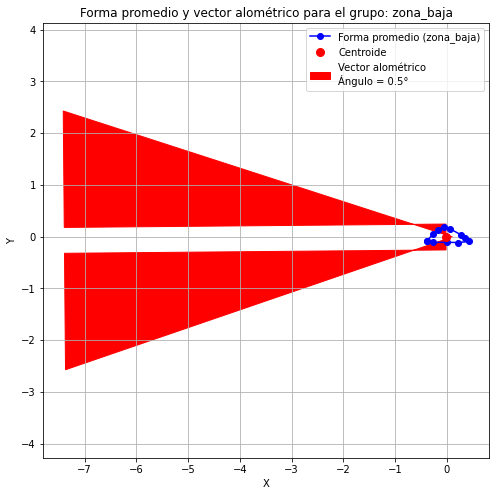

In [18]:
plot_group_average_and_alometric_vector(df, "zona_baja")

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut, cross_val_score
import itertools

#########################
# Paso 0: Preparar los datos de forma
#########################
def extract_shape_matrix(df, include_consensus=False):
    """
    Extrae la matriz de formas a partir de la columna 'pts'.
    Cada fila es la configuración de landmarks aplanada (1D).
    
    Parámetros:
      - df: DataFrame con la columna 'pts'
      - include_consensus: Si es False, se excluyen las filas cuyo specimen_id contiene "_gpa".
    
    Retorna:
      - X: matriz de forma (n_specimens, p) donde p = 2*n_landmarks
      - groups: vector con la etiqueta de grupo para cada espécimen.
    """
    if not include_consensus:
        df_ind = df[~df['specimen_id'].str.contains("_gpa")].copy()
    else:
        df_ind = df.copy()
    X = np.array([np.array(row['pts']).flatten() for _, row in df_ind.iterrows()])
    groups = df_ind['group'].values
    return X, groups







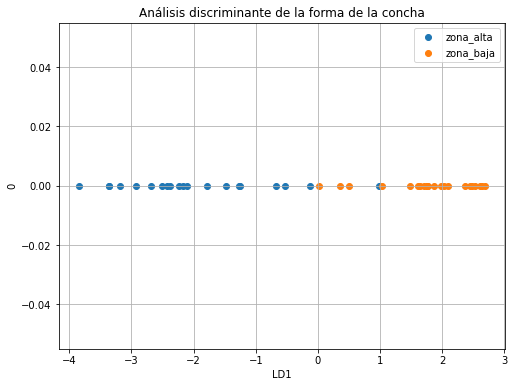

In [21]:
#########################
# Paso 1: Análisis discriminante (LDA)
#########################
def run_discriminant_analysis(df):
    """
    Aplica Linear Discriminant Analysis (LDA) sobre la matriz de formas y visualiza los
    discriminantes (ej. LD1 y LD2) para ver los componentes que maximizan la separación entre grupos.
    """
    X, groups = extract_shape_matrix(df, include_consensus=False)
    lda = LinearDiscriminantAnalysis()
    lda_scores = lda.fit_transform(X, groups)
    
    plt.figure(figsize=(8, 6))
    unique_groups = np.unique(groups)
    # Si solo se obtiene una dimensión (por ejemplo, si hay dos grupos), se grafica en el eje x y se pone cero en y.
    if lda_scores.shape[1] == 1:
        for grp in unique_groups:
            idx = groups == grp
            plt.scatter(lda_scores[idx, 0], np.zeros(np.sum(idx)), label=grp)
        plt.xlabel("LD1")
        plt.ylabel("0")
    else:
        for grp in unique_groups:
            idx = groups == grp
            plt.scatter(lda_scores[idx, 0], lda_scores[idx, 1], label=grp)
        plt.xlabel("LD1")
        plt.ylabel("LD2")
    plt.title("Análisis discriminante de la forma de la concha")
    plt.legend()
    plt.grid(True)
    plt.show()
    
#########################
# Ejecución de los análisis
#########################
# Supongamos que ya tienes tu DataFrame "df" que incluye:
# - 'specimen_id', 'group', 'pts', 'centroid_size', 'centroide'
# - Y la fila consenso (specimen_id con "_gpa") para cada grupo.
#
# 1) Análisis discriminante:
run_discriminant_analysis(df)




In [23]:
#########################
# Paso 2: Hotelling T² con test de permutación
#########################
def hotelling_t2_test(X1, X2, epsilon=1e-6):
    """
    Calcula la estadística Hotelling T² para dos grupos X1 y X2, 
    aplicando regularización a la matriz de covarianza para evitar singularidad.
    """
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    mean1 = np.mean(X1, axis=0)
    mean2 = np.mean(X2, axis=0)
    diff = mean1 - mean2
    S1 = np.cov(X1, rowvar=False)
    S2 = np.cov(X2, rowvar=False)
    Sp = ((n1 - 1)*S1 + (n2 - 1)*S2) / (n1 + n2 - 2)
    
    # Regularización: se suma epsilon a la diagonal
    Sp_reg = Sp + epsilon * np.eye(Sp.shape[0])
    
    T2 = (n1 * n2) / (n1 + n2) * diff.T.dot(np.linalg.inv(Sp_reg)).dot(diff)
    return T2

def run_hotelling_permutation(df, n_permutations=100):
    """
    Para cada par de grupos, calcula la estadística Hotelling T² y realiza
    un test de permutación con n_permutations para evaluar la significación.
    Imprime los resultados.
    """
    X, groups = extract_shape_matrix(df, include_consensus=False)
    pairwise_results = {}
    unique_groups = np.unique(groups)
    
    for grp1, grp2 in itertools.combinations(unique_groups, 2):
        X1 = X[groups == grp1]
        X2 = X[groups == grp2]
        T2_obs = hotelling_t2_test(X1, X2)
        # Permutación
        combined = np.vstack([X1, X2])
        n1 = X1.shape[0]
        perm_stats = []
        for i in range(n_permutations):
            perm = np.random.permutation(combined.shape[0])
            X1_perm = combined[perm[:n1]]
            X2_perm = combined[perm[n1:]]
            T2_perm = hotelling_t2_test(X1_perm, X2_perm)
            perm_stats.append(T2_perm)
        p_value = np.mean(np.array(perm_stats) >= T2_obs)
        pairwise_results[(grp1, grp2)] = (T2_obs, p_value)
        print(f"Comparación {grp1} vs {grp2}: T² = {T2_obs:.3f}, p-value = {p_value:.3f}")
    return pairwise_results

# 2) Test Hotelling T² con permutación:
pairwise_results = run_hotelling_permutation(df, n_permutations=100)



Comparación zona_alta vs zona_baja: T² = 144.185, p-value = 0.010


In [24]:
#########################
# Paso 3: Leave-One-Out Cross-Validation
#########################
def run_leave_one_out_cv(df):
    """
    Calcula la accuracy de clasificación usando Leave-One-Out Cross-Validation (LOO CV)
    sobre la matriz de formas (extraída de la columna 'pts') utilizando LDA.
    """
    X, groups = extract_shape_matrix(df, include_consensus=False)
    loo = LeaveOneOut()
    lda = LinearDiscriminantAnalysis()
    cv_scores = cross_val_score(lda, X, groups, cv=loo)
    accuracy = np.mean(cv_scores)
    print("Accuracy LOO-CV:", accuracy)
    return accuracy

# 3) Leave-One-Out Cross-Validation:
accuracy = run_leave_one_out_cv(df)

Accuracy LOO-CV: 0.7380952380952381
